# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
!pip install split-folders

In [2]:
# import the libraries
import os
import cv2
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import splitfolders
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
print(torch.__version__)

0.4.0


In [13]:
# Specifign the appropriate transformations, and batch_sizes

# dataloader parameters
batch_size = 40
num_workers = 0
categories = []

# training, test data directories
data_dir = '/data/landmark_images'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

transform = {
    # train
    'train':
        transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
    # test
    'test':
        transforms.Compose([
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=transform['train'])
test_data = datasets.ImageFolder(test_dir, transform=transform['test'])

# prepping the validation dataset
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx , valid_idx = indices[split:], indices[:split]
'''
indices = [[] for _ in range(len(datasets))]
for idx, (_, class_idx) in enumerate(datasets):
    indices[class_idx].append(idx)
train_indices, val_indices = [], []
for class_indices in indexs:
    size = len(class_indices)
    split = int(np.floor(validation_split * size))
    np.random.shuffle(class_indices)
    train_indices.extend(class_indices[split:])
    val_indices.extend(class_indices[:split])
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
'''
# Iterate through each category in test_Dir to use in prediction later
for d in os.listdir(test_dir):
    categories.append(d)

df = pd.DataFrame(categories, columns =['category'])
print(len(df['category']))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data ,  batch_size=batch_size  , num_workers=num_workers  , sampler = train_sampler)
valid_loader = DataLoader(train_data  ,  batch_size=batch_size  , num_workers=num_workers ,  sampler = valid_sampler)
test_loader  = DataLoader(test_data  ,  batch_size=batch_size  , num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

50


In [14]:
# print out some data stats
print('Number of training images {}'.format(len(train_data)))
print('Number of testing images {}'.format(len(test_data)))

# creating an iterator
dataiter = iter(loaders_scratch['valid'])
images, labels = dataiter.next()
print(images.shape)

Number of training images 4996
Number of testing images 1250
torch.Size([40, 3, 224, 224])


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:  
- I took the general rule and resized the images into 256*256 pixel image. To make the model robust, I added some distorts to image like rotation into some angle, horizontal and vetical flips. A different random transformation is applied to each epoch (while training), so the leraning process has maximum variation data available to learn. All of the data is also converted to Torch Tensors before normalization Then, I decided to flip and rotate the datasets randomly by choosing RandomHorizontalFlip & RandomRotation to make the model robust while training. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

(800, 600, 3)


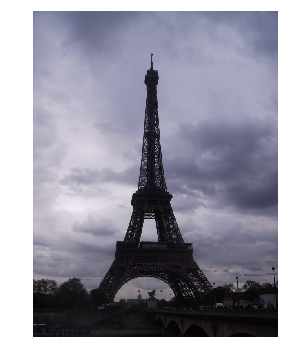

In [6]:
#function that will plot a tensor as an image to show how augmentation works.
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

# display image and its dimensions
def imshow(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(train_dir +'16.Eiffel_Tower/01dbdce476ecaa76.jpg')
print(np.array(x).shape)
imshow(x)

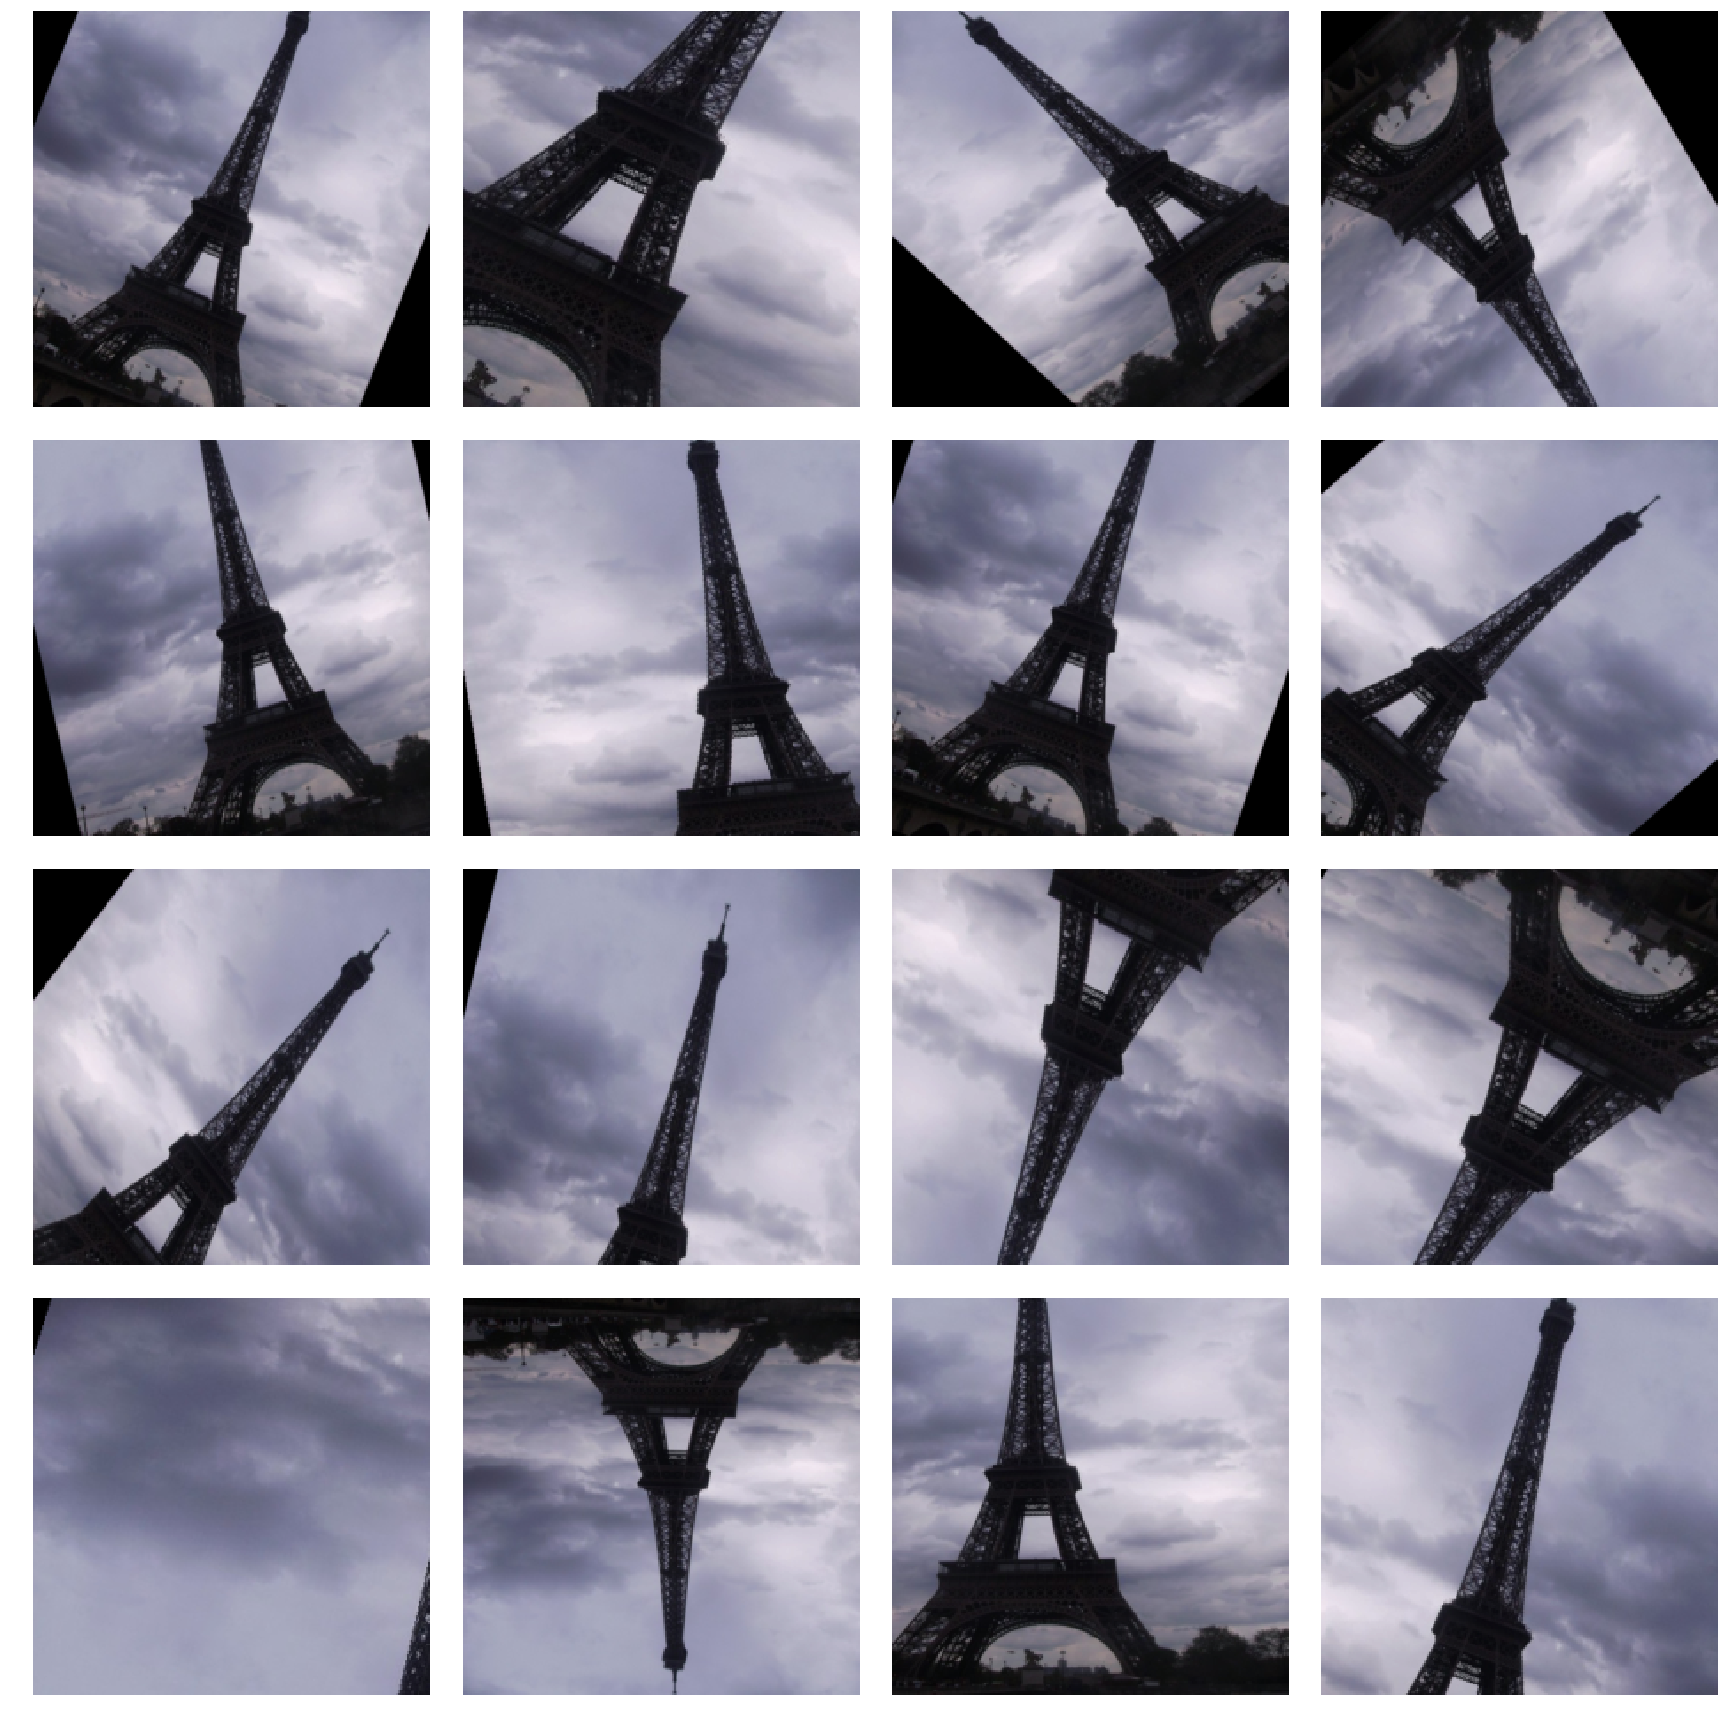

In [7]:
t = transform['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(x), ax=ax)

plt.tight_layout()

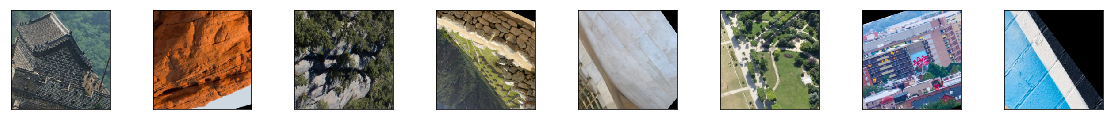

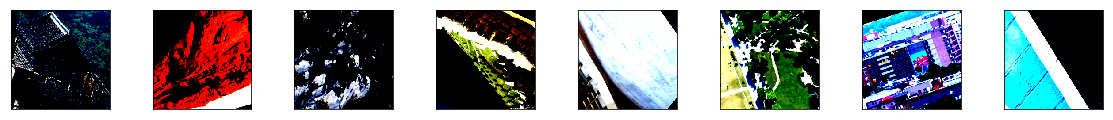

In [8]:
# visualize a batch of the train data loader

data_iter = iter(loaders_scratch['train'])
images, labels = data_iter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
r = np.arange(8)
for idx in r:
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = np.transpose(images[idx], (1, 2, 0))
    
    # reverse the normalization
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    plt.imshow(np.clip(img, 0, 1))

fig = plt.figure(figsize=(25, 4))
for idx in r:
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = np.transpose(images[idx], (1, 2, 0))
    plt.imshow(np.clip(img, 0, 1))

### Initialize use_cuda variable

In [15]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [16]:
# define a loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    optimizer = optim.SGD(model.parameters(), lr = 0.02 , momentum = 0.9)
    return optimizer    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [17]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # Pooling Layers
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers, final output of 133 for our # of dog breeds
        self.fc1 = nn.Linear(256 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096,50)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        # print(x.shape) # -->> debug purposes
        # Flatten image into vector, pass to FC layers
        x = x.view(-1, 256 * 7 * 7)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
- Initially, I decided to pick 5 convolutional layers. I chose this number because I tested different numbers and found 5 is good to capture the image representation and to be adequate for overall training speed. Then, I followed every convolutional layer by a max-pooling layer to down-sample an input representation. The CNN architecture ended up with 2 fully connected layers in order to reduce the output to the number of 50 landmark places. To make the model robust, Dropout layer is used after every FC layer. This means that during each epoch of training 40% of the neurons are randomly discarded

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradient
            optimizer.zero_grad()
            
            # forward propogation
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward propogation
            loss.backward()
            
            # optimzation
            optimizer.step()
            
            # record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
        if np.isnan(loss.item()):
            print('NAN loss. Ending training')
            break
         
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # forward propogation
            output = model(data)
            
            
            # calculate the batch loss
            loss = criterion(output, target)

            ## TODO: update average validation loss 
            valid_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
                print(' Loss decrease of {:.9f} <<<'.format(valid_loss_min - valid_loss))
                # save model
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
                no_loss = 0
        else:
                no_loss += 1

            ## Early stopping. End training if loss is no longer decreasing.
        if no_loss >= 5:
                print("No more loss. Terminating session.")
                break

    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [ ]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

epoch = 20
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(epoch, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.913285 	Validation Loss: 3.912860
 Loss decrease of inf <<<
Epoch: 2 	Training Loss: 3.868005 	Validation Loss: 3.869266
 Loss decrease of 0.043594657 <<<
Epoch: 3 	Training Loss: 3.835563 	Validation Loss: 3.843302
 Loss decrease of 0.025964263 <<<
Epoch: 4 	Training Loss: 3.813224 	Validation Loss: 3.807765
 Loss decrease of 0.035536596 <<<
Epoch: 5 	Training Loss: 3.758190 	Validation Loss: 3.760173
 Loss decrease of 0.047591958 <<<
Epoch: 6 	Training Loss: 3.705507 	Validation Loss: 3.704342
 Loss decrease of 0.055830761 <<<
Epoch: 7 	Training Loss: 3.671065 	Validation Loss: 3.678282
 Loss decrease of 0.026059794 <<<


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs =  100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)   
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained = True)
for param in model_transfer.parameters():
    param.requires_grad_(False)

    
model_transfer.classifier[6]  = nn.Linear(4096, 50, bias=True)
for param in model_transfer.classifier[6].parameters():
    param.requires_grad_(True)
    
print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

In [ ]:
model_transfer_resnet = models.resnet50(pretrained=True)
for param in model_transfer_resnet.parameters():
    param.requires_grad_(False)
    
model_transfer_resnet.fc  = nn.Linear(2048, 50, bias=True)
for param in model_transfer_resnet.fc.parameters():
    param.requires_grad_(True)
    
print(model_transfer_resnet)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer_resnet = model_transfer_resnet.cuda()

In [ ]:
model_transfer_vgg19 = models.vgg19(pretrained=True)
for param in model_transfer_vgg19.parameters():
    param.requires_grad_(False)
    
model_transfer_vgg19.classifier[6]  = nn.Linear(4096, 50, bias=True)
for param in model_transfer_vgg19.classifier[6].parameters():
    param.requires_grad_(True)  
    
print(model_transfer_vgg19)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer_vgg19 = model_transfer_vgg19.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
- I tried out 3 different models VGG16,VGG19 and RESNET50. I was about to use VGG16 with the defualt value of 20 epochs and train the last linear layer by replacing it with the fully connected layer with output 50. But, I got a bad accuracy less than the required accuracy which is 62% despite how many epochs I was running. Both VGG16 & VGG19 models also took long time to run which led me to look for a model that is more complex and fast to train. I was able to achieve 68% test accuracy using ResNet compared to the VGG models.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'

num_epochs = 20
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer.classifier[6]), criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [ ]:
# TODO: train the ResNet model and save the best model parameters at filepath 'model_transfer.pt'

num_epochs = 20
model_transfer_resnet = train(num_epochs, loaders_transfer, model_transfer_resnet, get_optimizer_transfer(model_transfer_resnet.fc), criterion_transfer, use_cuda, 'model_transfer_resnet.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer_resnet.load_state_dict(torch.load('model_transfer_resnet.pt',map_location=lambda storage, loc: storage))

In [ ]:
# TODO: train the VGG 19 model and save the best model parameters at filepath 'model_transfer.pt'

num_epochs = 20
model_transfer_vgg19 = train(num_epochs, loaders_transfer, model_transfer_vgg19, get_optimizer_transfer(model_transfer_vgg19.classifier[6]), criterion_transfer, use_cuda, 'model_transfer_vgg19.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer_vgg19.load_state_dict(torch.load('model_transfer_vgg19.pt',map_location=lambda storage, loc: storage))

In [ ]:
# mapping of classes to indexes and indexes to classes
model_transfer_resnet.class_to_idx = train_data.class_to_idx
model_transfer_resnet.idx_to_class = {
    idx: class_
    for class_, idx in model_transfer_resnet.class_to_idx.items()
}

list(model_transfer_resnet.idx_to_class.items())[:10]

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

In [ ]:
test(loaders_transfer, model_transfer_resnet, criterion_transfer, use_cuda)

In [ ]:
test(loaders_transfer, model_transfer_vgg19, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
#This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations 
#as was done to the validation data: cropping (center) and normalizing with means and standard deviations.
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

#Example of test images
x = process_image('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')
print(x.shape)
    

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(image_path, topk):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    """Make a prediction for an image using a Resnet50 model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if use_cuda:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model_transfer_resnet.eval()
        # Model outputs log probabilities
        out = model_transfer_resnet(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model_transfer_resnet.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

    return img_tensor.cpu().squeeze(), top_p, top_classes, real_class
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(image_path):
    """Display image and preditions from model"""

    # get landmark predictions
    img, ps, classes, y_obs = predict_landmarks(image_path, 5)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    ## TODO: display image and display landmark predictions
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
- the model worked as expected for 3 of the four external images. The model isn't able to figure out the specific of mountain ranges. So maybe to tackle this, we can add more CNN layers or maybe try the RNN approach because unlike others, mountain pictures do contain other information as well that can be used to determine whether it is mountain or not mountain.
- For other model worked as expected. we can try to 
        change the model architecture, 
        instead of RELU maybe try some different activation function and 
        also try to add one featuer extraction layer so that nearby surronding context can be used by model to determine the class.

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/mount.jpg')


In [ ]:
suggest_locations('images/brooklyn_bridge.jpg')

In [ ]:
suggest_locations('images/sydney.jpg')

In [ ]:

suggest_locations('images/forth_bridge.jpg')